In [1]:
# 패키지 로드
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from collections import defaultdict
import os, random

from scipy import sparse
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from torch.nn.init import normal_
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

#import plotnine
#from plotnine import *

In [2]:
# 경로 설정
data_path = '/Data2/hm22/New/data'
saved_path = '/Data2/hm22/New/code/saved'
output_path = '/Data2/hm22/New/code/submission'

In [3]:
# 데이터 불러오기 
meta = pd.read_csv(os.path.join(data_path, 'meta_data.csv'), encoding='utf-8')
metaplus = pd.read_csv(os.path.join(data_path, 'meta_data_plus.csv'), encoding='utf-8')

In [4]:
mt = meta.copy()
mtp = metaplus.copy()

In [5]:
mt.head()

,album_id,title,sub_title,genre_large,genre_mid,genre_small,country,run_time,onair_date,cast_1,cast_2,cast_3,cast_4,cast_5,cast_6,cast_7
0,749,어둠이 무서워요,꼬마버스 타요1,키즈,TV만화,NaN,한국,660,NaN,타요,로기,라니,가니,시투,NaN,NaN
1,750,우리는 친구,꼬마버스 타요1,키즈,TV만화,NaN,한국,660,NaN,타요,로기,라니,가니,시투,NaN,NaN
2,2131,타요의 첫 운행,꼬마버스 타요1,키즈,TV만화,NaN,한국,660,NaN,타요,로기,라니,가니,시투,NaN,NaN
3,2625,길 잃은 타요,꼬마버스 타요1,키즈,TV만화,NaN,한국,660,NaN,타요,로기,라니,가니,시투,NaN,NaN
4,2594,새내기 꼬마 버스의 하루,꼬마버스 타요1,키즈,TV만화,NaN,한국,660,NaN,타요,로기,라니,가니,시투,NaN,NaN


In [6]:
mtp.head()

,album_id,keyword_type,keyword_name,keyword_value
0,749,05010101,시리즈,0
1,749,05010302,EBS,0
2,749,05010401,3세,0
3,749,05010402,4세,0
4,749,05010407,1세,0


In [7]:
print('mt 데이터 : ', mt.shape)
print('mtp 데이터 : ', mtp.shape)

mt 데이터 :  (42602, 16)
mtp 데이터 :  (767948, 4)


#### 1. 중복 데이터 제거

In [8]:
# 중복행 확인
mt[mt.duplicated()]

,album_id,title,sub_title,genre_large,genre_mid,genre_small,country,run_time,onair_date,cast_1,cast_2,cast_3,cast_4,cast_5,cast_6,cast_7


In [9]:
mtp[mtp.duplicated()]

,album_id,keyword_type,keyword_name,keyword_value


#### 2. 결측치 제거

In [10]:
mt.isnull().sum().to_frame()

,0
album_id,0
title,0
sub_title,0
genre_large,0
genre_mid,0
genre_small,29183
country,8868
run_time,0
onair_date,37258
cast_1,14999


In [11]:
for col in mt.columns:
    msg = 'column: {:>10}\t Percent of NaN Value: {:.2f}%'.format(col, 100 * (mt[col].isnull().sum() / mt[col].shape[0]))
    print(msg)

column:   album_id	 Percent of NaN Value: 0.00%
column:      title	 Percent of NaN Value: 0.00%
column:  sub_title	 Percent of NaN Value: 0.00%
column: genre_large	 Percent of NaN Value: 0.00%
column:  genre_mid	 Percent of NaN Value: 0.00%
column: genre_small	 Percent of NaN Value: 68.50%
column:    country	 Percent of NaN Value: 20.82%
column:   run_time	 Percent of NaN Value: 0.00%
column: onair_date	 Percent of NaN Value: 87.46%
column:     cast_1	 Percent of NaN Value: 35.21%
column:     cast_2	 Percent of NaN Value: 48.25%
column:     cast_3	 Percent of NaN Value: 61.36%
column:     cast_4	 Percent of NaN Value: 70.69%
column:     cast_5	 Percent of NaN Value: 85.02%
column:     cast_6	 Percent of NaN Value: 93.88%
column:     cast_7	 Percent of NaN Value: 98.21%


- 하지만 **70~80%** 가 비어 있는 변수라면 분석하기 어렵고, 이를 사용하기도 어렵기에 지우는 게 나을 수 있음
    - **Dropping Variable**
        - **onair_date**
        - **cast_4**
        - **cast_5**
        - **cast_6**
        - **cast_7**

In [12]:
mtp.isnull().sum().to_frame()

,0
album_id,0
keyword_type,0
keyword_name,0
keyword_value,0


In [13]:
# 1. genre_small
print('대분류 장르 : ' , mt.genre_large.unique())
print('중분류 장르 : ' , mt.genre_mid.unique())
print('소분류 장르 : ' , mt.genre_small.unique())

대분류 장르 :  ['키즈' '방송' '애니' '영화' '라이프' '다큐']
중분류 장르 :  ['TV만화' '애니' '한자' '노래율동' '놀이교실' '예능' '창의학습' '드라마' '시리즈' '연예오락' '코미디'
 '극장판 애니' '액션/모험' '예술' '독서동화' '책' '역사/문화' '외국어' '시사교양' '휴먼/감동' '체육안전'
 '유아애니' '육아정보' '다큐멘터리' 'MCN' '어린이방송' '노래 율동' '수학과학' '한글']
소분류 장르 :  [nan '영어' '창의학습' '수학과학' '한글' '예술교육' '코믹/명랑' '독서동화' '생활교육' '순정/학원' '액션/모험'
 '어린이/가족' '기타' '오페라' '한자' '클래식 콘서트' '장난감놀이' '미술/전시' 'EBS' 'SF/판타지' '체육안전']


In [14]:
mt = mt.drop(['genre_small'], axis = 1)

In [ ]:
# 2. country
for i in mt['album_id'].value_counts().index : 
    
    if mt['album_id'].value_counts().loc[i] > 1 :
        if mt[mt['album_id']== i].country.isnull() is True : 
            print(mt[mt['album_id']== i])
    
print("done")

## 같은 album_id인데 국가가 비어있는 항목은 없음

In [15]:
mt.loc[mt['country'].isnull() == True, 'country'] = '기타'

## Nan 값을 ‘기타’항목으로 변환

In [16]:
mt.isnull().sum().to_frame()

,0
album_id,0
title,0
sub_title,0
genre_large,0
genre_mid,0
country,0
run_time,0
onair_date,37258
cast_1,14999
cast_2,20554


In [ ]:
# 3. onair_date
###### 방법 1
#mt = mt.drop(['onair_date'], axis = 1)

###### 방법 2
#multiple imputation by chained equations (MICE)

In [17]:
# 4. cast_1, cast_2, cast_3, cast_4, cast_5, cast_6, cast_7
##### cast_1, cast_2, cast_3 -> Nan값 기타 처리
mt.loc[mt['cast_1'].isnull() == True, 'cast_1'] = '기타'
mt.loc[mt['cast_2'].isnull() == True, 'cast_2'] = '기타'
mt.loc[mt['cast_3'].isnull() == True, 'cast_3'] = '기타'

#####  cast_4, cast_5, cast_6, cast_7 -> 결측치 비율 너무 많아서 drop
mt = mt.drop(['cast_4', 'cast_5', 'cast_6', 'cast_7'], axis = 1) 

#### 3. 이상치 확인

In [18]:
mt

,album_id,title,sub_title,genre_large,genre_mid,country,run_time,onair_date,cast_1,cast_2,cast_3
0,749,어둠이 무서워요,꼬마버스 타요1,키즈,TV만화,한국,660,NaN,타요,로기,라니
1,750,우리는 친구,꼬마버스 타요1,키즈,TV만화,한국,660,NaN,타요,로기,라니
2,2131,타요의 첫 운행,꼬마버스 타요1,키즈,TV만화,한국,660,NaN,타요,로기,라니
3,2625,길 잃은 타요,꼬마버스 타요1,키즈,TV만화,한국,660,NaN,타요,로기,라니
4,2594,새내기 꼬마 버스의 하루,꼬마버스 타요1,키즈,TV만화,한국,660,NaN,타요,로기,라니
...,...,...,...,...,...,...,...,...,...,...,...
42597,39873,로티프렌즈와 색칠놀이! - 그리피 ＆ 사탕 바구니,로티프렌즈 미술놀이,키즈,놀이교실,한국,477,NaN,기타,기타,기타
42598,39874,로티프렌즈와 색칠놀이! - 베블리 ＆ 꽃,로티프렌즈 미술놀이,키즈,놀이교실,한국,466,NaN,기타,기타,기타
42599,4779,손가락을 빨게 돼요,4-5세,키즈,책,한국,293,NaN,기타,기타,기타
42600,4779,손가락을 빨게 돼요,아이맘콕,키즈,책,한국,293,NaN,기타,기타,기타


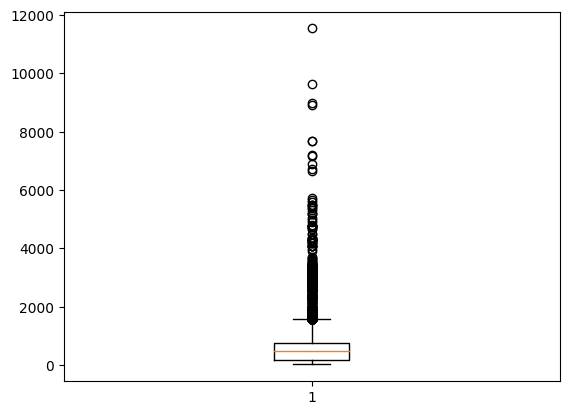

In [19]:
fig, ax = plt.subplots()
ax.boxplot(mt['run_time'])
plt.show()

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

In [21]:
mt02 = mt.copy()
mt02 = mt02[['run_time']]

In [22]:
outlier = LocalOutlierFactor()
mt02["outlier"] = outlier.fit_predict(mt02)

In [23]:
# 이상치 탐지 (이상치 있는 행 찾기)
mt02[mt02["outlier"] == -1]

,run_time,outlier
210,566,-1
238,1425,-1
243,554,-1
260,1338,-1
263,474,-1
...,...,...
42431,267,-1
42534,379,-1
42535,379,-1
42556,328,-1


In [24]:
mt = mt.drop(mt02[mt02["outlier"] == -1].index, axis = 0)

In [25]:
print('mt 데이터(이상치 제거 후) : ', mt.shape)

mt 데이터(이상치 제거 후) :  (40719, 11)


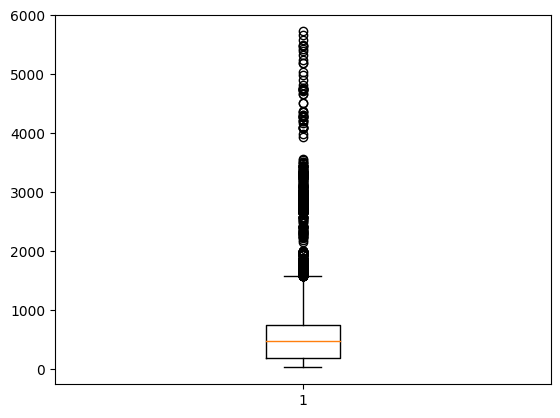

In [26]:
fig, ax = plt.subplots()
ax.boxplot(mt['run_time'])
plt.show()

#### 4. 데이터 병합

In [27]:
mt.head()

,album_id,title,sub_title,genre_large,genre_mid,country,run_time,onair_date,cast_1,cast_2,cast_3
0,749,어둠이 무서워요,꼬마버스 타요1,키즈,TV만화,한국,660,NaN,타요,로기,라니
1,750,우리는 친구,꼬마버스 타요1,키즈,TV만화,한국,660,NaN,타요,로기,라니
2,2131,타요의 첫 운행,꼬마버스 타요1,키즈,TV만화,한국,660,NaN,타요,로기,라니
3,2625,길 잃은 타요,꼬마버스 타요1,키즈,TV만화,한국,660,NaN,타요,로기,라니
4,2594,새내기 꼬마 버스의 하루,꼬마버스 타요1,키즈,TV만화,한국,660,NaN,타요,로기,라니


In [28]:
mtp.head()

,album_id,keyword_type,keyword_name,keyword_value
0,749,05010101,시리즈,0
1,749,05010302,EBS,0
2,749,05010401,3세,0
3,749,05010402,4세,0
4,749,05010407,1세,0


In [29]:
mt.shape, mtp.shape

((40719, 11), (767948, 4))

In [30]:
%%time
mdf01 = pd.merge(mt, mtp, on = ['album_id'], how = 'left')
mdf01

CPU times: user 228 ms, sys: 216 ms, total: 444 ms
Wall time: 442 ms


,album_id,title,sub_title,genre_large,genre_mid,country,run_time,onair_date,cast_1,cast_2,cast_3,keyword_type,keyword_name,keyword_value
0,749,어둠이 무서워요,꼬마버스 타요1,키즈,TV만화,한국,660,NaN,타요,로기,라니,05010101,시리즈,0
1,749,어둠이 무서워요,꼬마버스 타요1,키즈,TV만화,한국,660,NaN,타요,로기,라니,05010302,EBS,0
2,749,어둠이 무서워요,꼬마버스 타요1,키즈,TV만화,한국,660,NaN,타요,로기,라니,05010401,3세,0
3,749,어둠이 무서워요,꼬마버스 타요1,키즈,TV만화,한국,660,NaN,타요,로기,라니,05010402,4세,0
4,749,어둠이 무서워요,꼬마버스 타요1,키즈,TV만화,한국,660,NaN,타요,로기,라니,05010407,1세,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
798604,11629,손가락 하나,베이비 타요 동요2,키즈,노래율동,한국,91,NaN,타요와 친구들,기타,기타,05040104,신나는,0
798605,11629,손가락 하나,베이비 타요 동요2,키즈,노래율동,한국,91,NaN,타요와 친구들,기타,기타,0504010b,따라하고 싶은,0
798606,11629,손가락 하나,베이비 타요 동요2,키즈,노래율동,한국,91,NaN,타요와 친구들,기타,기타,05070e01,인체,0
798607,11629,손가락 하나,베이비 타요 동요2,키즈,노래율동,한국,91,NaN,타요와 친구들,기타,기타,05080401,캐릭터 친구들,0


In [31]:
mdf01.isnull().sum().to_frame()

,0
album_id,0
title,0
sub_title,0
genre_large,0
genre_mid,0
country,0
run_time,0
onair_date,721915
cast_1,0
cast_2,0


In [34]:
mdf01.to_csv('mdf_v1.csv')